In [4]:
import cv2
from skimage import io
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans
from scipy.cluster.vq import vq
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import joblib
%matplotlib inline

In [6]:
def load_objects_data(data_folder):
    data = []
    labels = []
    label_map = {}
    label_count = 0
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if not os.path.isdir(folder_path):
            continue
        if folder not in label_map:

          label_map[folder] = label_count
          label_count += 1
        label = label_map[folder]
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, 0)
            if img is None:
                continue
            data.append(img)
            labels.append(label)
      
        return data, labels

In [7]:
objects_train_data, objects_train_labels = load_objects_data("/content/drive/MyDrive/Assignment#01 (Dataset)/Objects_Dataset_Images/train")
objects_test_data, objects_test_labels = load_objects_data("/content/drive/MyDrive/Assignment#01 (Dataset)/Objects_Dataset_Images/test")

In [8]:
def split_flowers_data(data_folder, test_size=0.2):
    data = []
    labels = []
    label_map = {} # create an empty dictionary to map folder names to label numbers
    label_count = 0 # initialize label_count to zero
    for folder in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder)
        if not os.path.isdir(folder_path):
            continue
        if folder not in label_map: # add new folder name to label_map
            label_map[folder] = label_count
            label_count += 1
        label = label_map[folder]
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, 0)
            if img is None:
                continue
            data.append(img)
            labels.append(label)
    return train_test_split(data, labels, test_size=test_size, stratify=labels, random_state=42)

In [9]:
flowers_train_data, flowers_test_data, flowers_train_labels, flowers_test_labels = split_flowers_data("/content/drive/MyDrive/flower_photos")

In [10]:
features_extractor = cv2.xfeatures2d.SIFT_create() # create the sift object

train_keypoints = []
train_descriptors = []

test_keypoints = []
test_descriptors = []

for train_img in flowers_train_data:
  train_img_keypoints, train_img_descriptors = features_extractor.detectAndCompute(train_img, None) # extract the keypoints and descriptors for training
  train_keypoints.append(train_img_keypoints) # adding each keypoint in the train list 
  train_descriptors.append(train_img_descriptors) # adding each keypoint in the test list 

for test_img in flowers_test_data:
  test_img_keypoints, test_img_descriptors = features_extractor.detectAndCompute(test_img, None) # extract the keypoints and descriptors for testing
  test_keypoints.append(test_img_keypoints) # adding each descriptors in the train list 
  test_descriptors.append(test_img_descriptors)# adding each descriptors in the test list

In [11]:
# Printing the 1st five images descriptors shape
for i in train_descriptors[:5]:
  print(i.shape)

(301, 128)
(407, 128)
(337, 128)
(1055, 128)
(1435, 128)


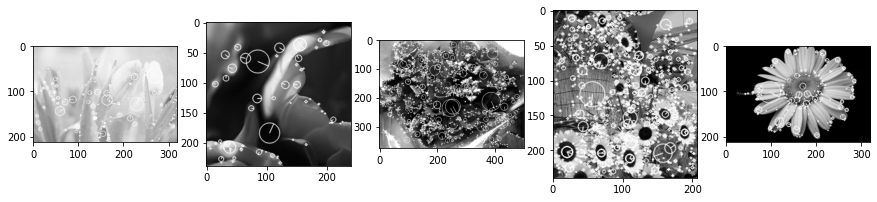

In [12]:
output_images = []
j = 0
plt.figure(figsize = (15,6))
l = [np.random.randint(800) for i in range(5)]
for i in l:
  output_images.append(cv2.drawKeypoints(flowers_train_data[i], train_keypoints[i], 0, (255,255,255), flags = cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
  ax = plt.subplot(1,5,j+1)
  plt.imshow(output_images[j])
  j += 1
plt.show()

In [13]:
features_extractor = cv2.xfeatures2d.SIFT_create() # create the sift object

train_keypoints = []
train_descriptors = []

test_keypoints = []
test_descriptors = []

for train_img in objects_train_data:
  train_img_keypoints, train_img_descriptors = features_extractor.detectAndCompute(train_img, None) # extract the keypoints and descriptors for training
  train_keypoints.append(train_img_keypoints) # adding each keypoint in the train list 
  train_descriptors.append(train_img_descriptors) # adding each keypoint in the test list 

for test_img in objects_test_data:
  test_img_keypoints, test_img_descriptors = features_extractor.detectAndCompute(test_img, None) # extract the keypoints and descriptors for testing
  test_keypoints.append(test_img_keypoints) # adding each descriptors in the train list 
  test_descriptors.append(test_img_descriptors)# adding each descriptors in the test list

In [14]:
# Printing the 1st five images descriptors shape
for i in train_descriptors[:5]:
  print(i.shape)

(638, 128)
(389, 128)
(467, 128)
(503, 128)
(632, 128)


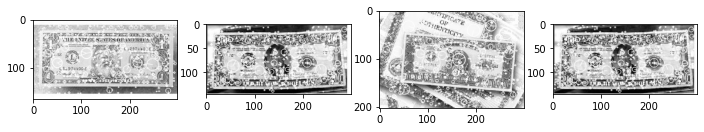

In [22]:
output_images = []
j = 0
plt.figure(figsize = (15,6))
l = [np.random.randint(20) for i in range(4)]
for i in l:
  output_images.append(cv2.drawKeypoints(objects_train_data[i], train_keypoints[i], 0, (255,255,255), flags = cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS))
  ax = plt.subplot(1,5,j+1)
  plt.imshow(output_images[j])
  j += 1
plt.show()

In [23]:
train_all_descriptors = []
test_all_descriptors = []

# storing all the descriptors of each image in one list
for train_des in train_descriptors:
  for local_descriptor in train_des:
    train_all_descriptors.append(local_descriptor) 

# storing all the descriptors of each image in one list
for test_des in test_descriptors:
  for local_descriptor in test_des:
    test_all_descriptors.append(local_descriptor)

train_all_descriptors = np.stack(train_all_descriptors)
test_all_descriptors = np.stack(test_all_descriptors)

In [24]:
train_all_descriptors.shape, test_all_descriptors.shape

((7298, 128), (542, 128))

In [25]:
k = 200 # number of clusters
iters = 1
codebook, variance = kmeans(train_all_descriptors, k, iters, seed = 10) # constructing a codebook

In [26]:
print(f'Codebook Shape{codebook.shape}')

Codebook Shape(200, 128)


In [27]:
train_visual_words = []
test_visual_words = []

for train_img_descriptors in train_descriptors:
  train_img_visual_words, distance = vq(train_img_descriptors, codebook)
  train_visual_words.append(train_img_visual_words)

for test_img_descriptors in test_descriptors:
  test_img_visual_words, distance = vq(test_img_descriptors, codebook)
  test_visual_words.append(test_img_visual_words)

In [28]:
# visual words looke like for image 0
print(f'Visual words in Image 0: {train_visual_words[0][:]}')

Visual words in Image 0: [113 197  37  13 153 117  34  16 185  13 187 195  93 185  89  67 144 190
  13  18 191 177   0  86  75  21 185  71  86 197  13 177  71 114 154   4
 136 185  15  83 150 112  71  13  72  60 122  78 135  26   4 164  32 172
 114  96  40  83 185 196   4  87   4  95 173  71 166 135  30 139  70 134
  36 152 112 185 151  17 168 185  13  75 191  49 193  36  54 193  53  93
  42  67  42  13 185   1  98 159  70  25  56  26  28 140  11 121  83 130
 184 195  28  71 164 117 173  71 160  95 165 148 155  73  63 160  94 116
 101  49 154  47 128 188 120 140 175 175 175 189  89 101 120  94  47 178
  67 121  67  39  31 195 107 178  12 188  95  15 188 167 129  55  91  35
 121 179 184 172 191  39   7 148 103 174 103 188  25  68  16   1 107 111
  18  96  30  30 112   2 199  72 185   2 108 127  46  68 166   8  75  71
  71  90  71  92  87 122 126 189  13  65   5  64  72 136 188  51   8 196
  75 133  47 187 167 121 169  17  79  73 184 175 130  53  88  13  92  72
 176  17 195 147  10 136  

In [29]:
train_frequency_vectors = []
test_frequency_vectors = []

for img_visual_words in train_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  train_frequency_vectors.append(img_frequency_vector) 

for img_visual_words in test_visual_words:
  img_frequency_vector = np.zeros(k) # k is the number of cluster (200)
  for word in img_visual_words:
    img_frequency_vector[word] += 1 # counting the frequency of the visual words 
  test_frequency_vectors.append(img_frequency_vector)

train_frequency_vectors = np.stack(train_frequency_vectors)
test_frequency_vectors = np.stack(test_frequency_vectors)

In [30]:
train_frequency_vectors.shape, test_frequency_vectors.shape

((14, 200), (2, 200))

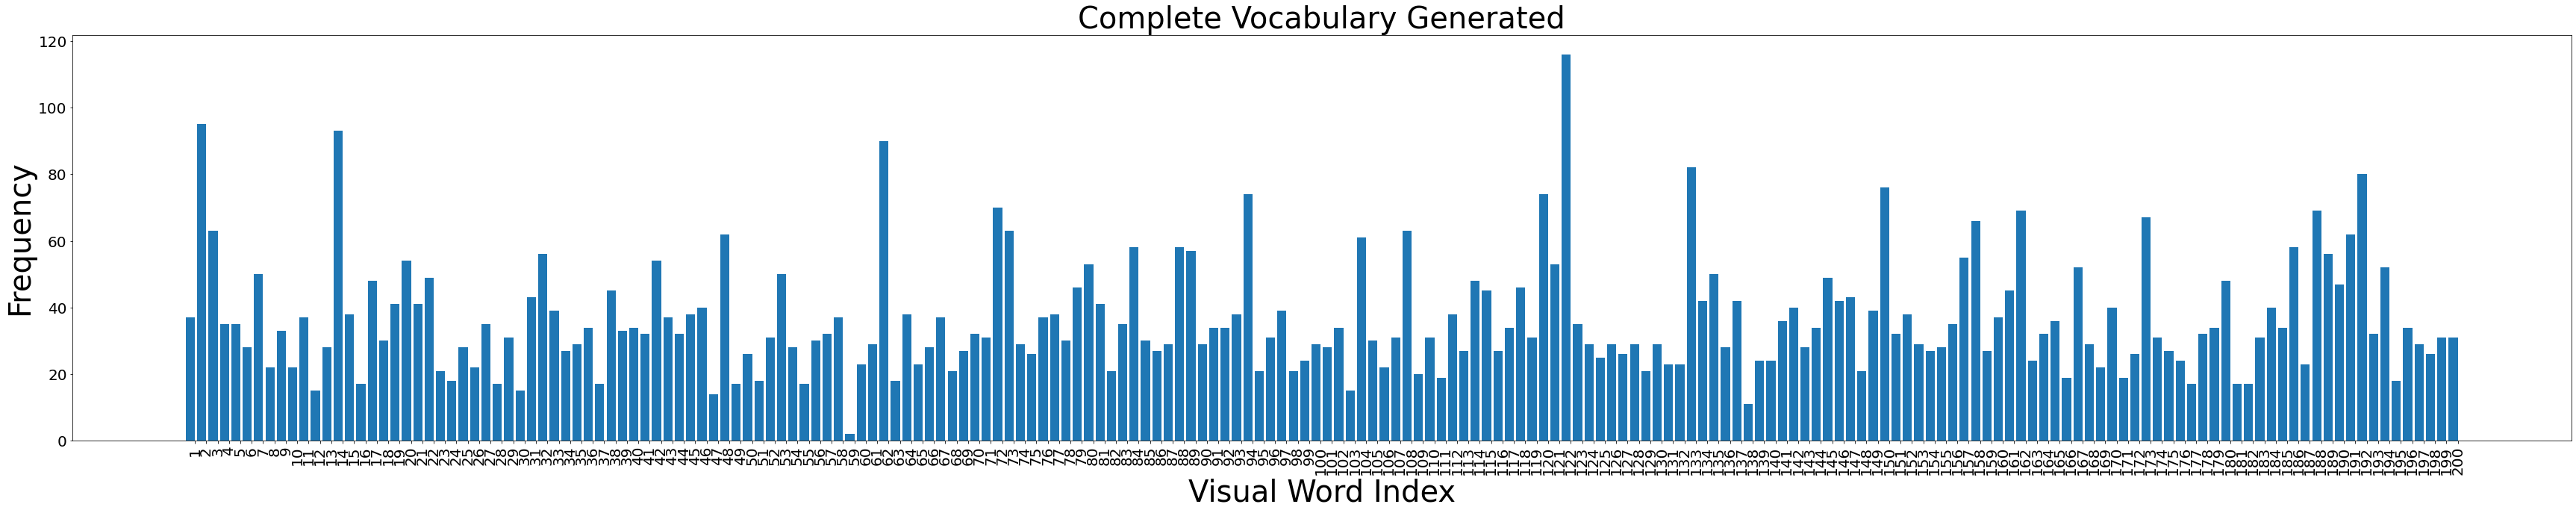

In [31]:
x_scalar = np.arange(1,k+1)
y_scalar = np.array([abs(np.sum(train_frequency_vectors[:,h], dtype=np.int32)) for h in range(k)])
plt.figure(figsize = (60,10))
plt.bar(x_scalar, y_scalar)
plt.xlabel("Visual Word Index", fontsize = 40)
plt.ylabel("Frequency", fontsize = 40)
plt.title("Complete Vocabulary Generated", fontsize = 40)
plt.xticks(x_scalar + 0.4, x_scalar, rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('complete vocabulary generated.jpg')
plt.show()

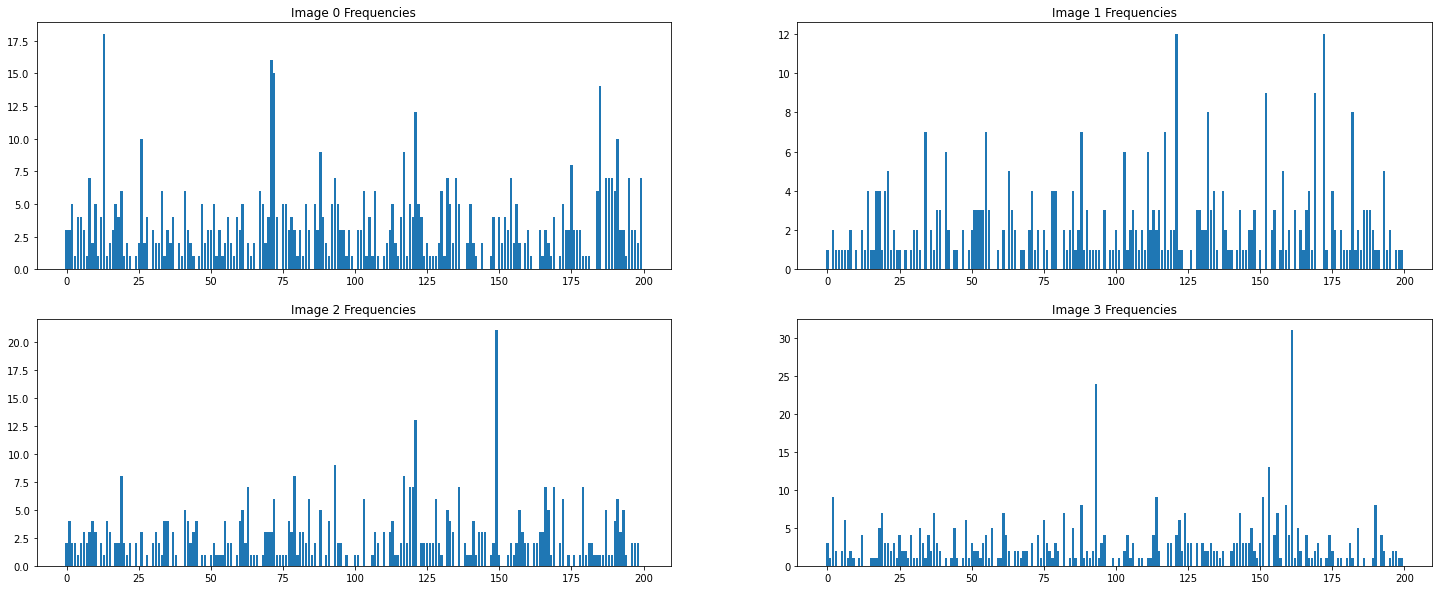

In [32]:
plt.figure(figsize = (25,10))
for i in range(4):
  ax = plt.subplot(2,2,i+1)
  plt.bar(list(range(k)), train_frequency_vectors[i])
  plt.title(f'Image {i} Frequencies')
plt.savefig('Images Frequencies.jpg')
plt.show()

In [33]:
# Scaling the words
stdSlr = StandardScaler().fit(train_frequency_vectors)
train_features = stdSlr.transform(train_frequency_vectors) # Normalizing the train features
test_features = stdSlr.transform(test_frequency_vectors) # Normalizing the test features

In [40]:
from sklearn.utils import shuffle
#Train an algorithm to discriminate vectors corresponding to positive and negative training images
clf = LinearSVC(max_iter = 10000, random_state = 100)  #Default of 100 is not converging
clf.fit(train_features, np.array(flowers_train_labels))

ValueError: ignored